# Práctica guiada

## Predicción de enfermedad cardíaca con Random Forest

<img src="img/heart-health-tips-animation-thumbnail.gif" alt="hearth">


El hospital de León quiere **predecir riesgo de enfermedad cardíaca** a partir de datos clínicos básicos de pacientes.


El objetivo **no es solo entrenar un modelo**, sino **decidir qué modelo es más adecuado**, cómo configurarlo y **explicar por qué**.

Trabajarás con:

* `heart.csv` → dataset completo
* `heart_disease_4features.csv` → versión reducida y más interpretable

El cuaderno base utiliza **Random Forest**, búsqueda de hiperparámetros y visualización de árboles .

---

## Resultados de aprendizaje trabajados

* **RA2.c** Define el modelo a implementar
* **RA2.d** Implementa la aplicación
* **RA2.e** Evalúa resultados

---

## Entrega

Un **notebook Jupyter** en formato PDF con:

* Código funcional
* Respuestas razonadas en Markdown
* Gráficas y métricas
* Conclusiones claras

---

## ¿Qué es Random Forest?

**Random Forest** es un algoritmo de **aprendizaje automático supervisado** que se utiliza tanto para **clasificación** como para **regresión**.

La idea principal es sencilla:

> En lugar de tomar una decisión con un solo árbol de decisión, Random Forest entrena **muchos árboles distintos** y combina sus resultados para obtener una predicción más fiable.

---

## ¿Cómo funciona?

1. Se crean **muchos subconjuntos distintos** del conjunto de entrenamiento (muestreo con reemplazo).
2. Con cada subconjunto se entrena **un árbol de decisión diferente**.
3. En cada árbol, las divisiones se hacen usando **solo una parte aleatoria de las variables**.
4. Para clasificar un nuevo dato:

   * Cada árbol da su predicción.
   * El modelo final decide por **votación mayoritaria**.

Este proceso reduce los errores debidos a:

* árboles demasiado complejos
* datos ruidosos
* sobreajuste al conjunto de entrenamiento

<img src="img/random-forest.png" alt="random forest">

---

## ¿Por qué no usar un solo árbol de decisión?

Un árbol de decisión:

* es fácil de entender
* pero **muy sensible a los datos**
* puede memorizar el entrenamiento (overfitting)

Random Forest soluciona esto porque:

* combina muchos árboles simples
* promedia sus decisiones
* generaliza mejor a datos nuevos

---

## Ventajas de Random Forest

* Funciona bien con **datos tabulares**
* No necesita normalización de variables
* Captura relaciones **no lineales**
* Es robusto frente al ruido
* Permite estimar la **importancia de las variables**

Por eso es muy utilizado en:

* medicina
* banca
* detección de fraude
* problemas reales con datos estructurados

---

## Inconvenientes

* Es menos interpretable que un solo árbol
* Consume más tiempo y recursos
* No es ideal cuando se necesita un modelo muy simple o explicable al 100%

Más información

[Machine Learning Google](https://developers.google.com/machine-learning/decision-forests?hl=es-419)

[Videotutorial: Random Forests con Python](https://www.youtube.com/watch?v=VfMPslt2wgA)

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score
)

## Parte 1 – Exploración y comprensión del dataset (obligatoria)

### 1.1 Carga de datos

Carga ambos datasets y responde:

In [3]:
df = pd.read_csv("data/heart.csv")
print(df.head())

df_reduce= pd.read_csv("data/heart_disease_4features.csv")
df_reduce.head()

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  


,Unnamed: 0,age,sex,trestbps,chol,target
0,0,52,1,125,212,0
1,1,53,1,140,203,0
2,2,70,1,145,174,0
3,3,61,1,148,203,0
4,4,62,0,138,294,0


<div style="background-color:green;color:white">

<br>

**Cuestiones (responde en Markdown):**

* ¿Cuántas variables tiene cada dataset?


* ¿Cuál crees que será más fácil de explicar a un médico?


* ¿Qué se pierde al reducir variables?


<br>

El dataset completo tiene 14 variables, el reducido tiene solo 5

Un médico debería de saber interpretar el completo, y sería mejor ya que le proporciona más datos.

Se pierden posibles datos importantes para la decisión correcta.

---

### 1.2 Variable objetivo

<div style="background-color:green;color:white">

<br>

* Identifica claramente la variable *objetivo*

* Explica qué significa *0* y *1*


* Comprueba si hay **desbalanceo de clases**


 <br>

La variable objetivo es la variable 'target' y el 0 significa que no tiene enfermedad cardíaca y el 0 por defecto que sí la tiene.

Distribución de la variable objetivo:
target
1    526
0    499
Name: count, dtype: int64

Porcentajes:
target
1    51.317073
0    48.682927
Name: proportion, dtype: float64


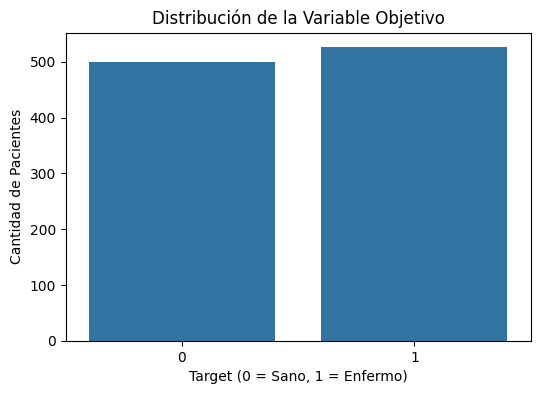

In [4]:
conteo = df['target'].value_counts()
porcentaje = df['target'].value_counts(normalize=True)*100

print("Distribución de la variable objetivo:")
print(conteo)
print("\nPorcentajes:")
print(porcentaje)

plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Distribución de la Variable Objetivo')
plt.xlabel('Target (0 = Sano, 1 = Enfermo)')
plt.ylabel('Cantidad de Pacientes')
plt.show()

## Parte 2 – Primer modelo Random Forest (baseline)

### 2.1 Separación train/test

Usa `train_test_split` con:

* `test_size=0.2`
* `random_state=42`



In [5]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state=42)

<div style="background-color:green;color:white">

<br>

Explica **por qué fijar la semilla es importante**.


<br>

Es importante para que la división en train y test sea siempre la misma y no varíe las distintas veces que corras el código.

---

### 2.2 Entrenamiento inicial

Entrena un **Random Forest controlado**, es decir, **no utilices el modelo con los valores por defecto**.

Para ello:

* Crea un `RandomForestClassifier` fijando **explícitamente varios hiperparámetros**.
* Debes **limitar la complejidad del modelo** para evitar sobreajuste.
* Asegura que el entrenamiento sea **reproducible**.
* Evita que el modelo tome decisiones basadas en **muy pocos ejemplos**.
* (Opcional) Activa una estimación interna del rendimiento.

El modelo debe entrenarse con los datos de entrenamiento (`X_train`, `y_train`).

📌 **Ayuda**
Consulta la documentación oficial de [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) en *scikit-learn* para identificar qué hiperparámetros permiten:

* controlar la profundidad de los árboles,
* fijar el número de árboles,
* imponer un tamaño mínimo en las hojas,
* y garantizar reproducibilidad.




In [6]:
rf = RandomForestClassifier(
    max_depth=5,
    min_samples_leaf=10,
    oob_score=True,
    random_state=42
    )

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=10, oob_score=True,
                       random_state=42)

---
## Parte 3 – Evaluación correcta del modelo

Una vez entrenado el modelo, es necesario **evaluar su rendimiento** para comprobar si es capaz de **generalizar correctamente** a datos que no ha visto durante el entrenamiento.

En esta parte no basta con obtener una predicción: se deben analizar **distintas métricas**, ya que cada una aporta información diferente sobre el comportamiento del modelo.

---

### Qué se va a hacer

Se evaluará el modelo utilizando el conjunto de test y se mostrarán:

* **Accuracy**
* **Matriz de confusión**
* **Informe de clasificación (classification report)**

Estas métricas permiten analizar no solo cuántas predicciones acierta el modelo, sino **qué tipo de errores comete**.

---

### Por qué no es suficiente una sola métrica

En problemas de clasificación, especialmente en contextos reales como la medicina, **no todos los errores tienen el mismo impacto**.
Por ejemplo, clasificar como sano a un paciente enfermo puede ser mucho más grave que el error contrario.

Por ello, es imprescindible analizar varias métricas y no quedarse solo con la accuracy.

---

- Accuracy: Indica el **porcentaje total de predicciones correctas**.


- Matriz de confusión: Muestra el **número de aciertos y errores por clase**, permite ver **qué tipo de errores son más frecuentes**.

- Classification report: Resume varias métricas clave para cada clase:

* **Precision**: de las predicciones positivas, cuántas son correctas.
* **Recall (sensibilidad)**: de los casos reales, cuántos detecta el modelo.
* **F1-score**: equilibrio entre precision y recall.

---




Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       102
           1       0.82      0.91      0.86       103

    accuracy                           0.85       205
   macro avg       0.86      0.85      0.85       205
weighted avg       0.86      0.85      0.85       205



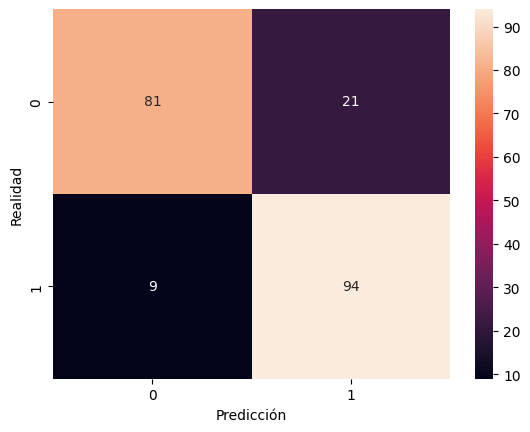

In [7]:
y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2}")

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()

<div style="background-color:green;color:white">

<br>


- ¿El rendimiento del modelo es adecuado?
- ¿Qué clase se predice mejor y cuál peor?
- ¿Qué tipo de error consideras más problemático en este contexto y por qué?
- ¿Es suficiente la accuracy en un problema médico?
- Justifica con un ejemplo concreto.


<br>

Es adecuado, pero no perfecto, para la clase 1 la precisión es algo baja, 0.82, pero el recall de 0.91 es bastante alto.

Acierta más en el caso de que el paciente esté sano.

El falso negativo es el más grave, ya que puedes dar por cerrado el caso de una persona con una posible enfermedad grave, que sin un tartamiento podría acabar con su fallecimiento.

No, porque las clases pueden no estar balanceadas o los costor de errores no son simétricos.

Una enfermedad muy rara que afecte a menos del 1% de la población, un mal modelo que diga que siempre está sana la gente acertaría en el 99% de las veces, y dejaría morir a ese 1% aun teniendo una accuracy casi perfecta.

---

## Parte 4 – Optimización con GridSearchCV

En esta parte se va a **optimizar el modelo Random Forest entrenado anteriormente** utilizando **validación cruzada**.

En lugar de fijar los hiperparámetros manualmente, se utilizará `GridSearchCV` para **probar distintas combinaciones** de valores y seleccionar automáticamente la que **mejor rendimiento medio** obtenga en validación cruzada.

Se repetirá la **misma estrategia utilizada en el cuaderno base**:

* Se variará la **profundidad máxima de los árboles**.
* Se limitará el **número mínimo de muestras por hoja** para evitar decisiones basadas en pocos datos.
* Se probarán distintos **números de árboles** en el bosque.
* El rendimiento se evaluará mediante **accuracy** y validación cruzada.

El objetivo **no es solo mejorar la métrica**, sino **comparar el modelo optimizado con el modelo controlado anterior** y reflexionar sobre el coste computacional.

---


In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "max_depth": [2, 3, 5, 10, 20],
    "min_samples_leaf": [5, 10, 20, 50, 100],
    "n_estimators": [10, 30, 50, 100]
}


rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)


A partir del modelo y del conjunto de hiperparámetros definidos anteriormente, configura un proceso de **búsqueda exhaustiva** de hiperparámetros utilizando `GridSearchCV`.

El proceso debe cumplir las siguientes condiciones:

* Utiliza como **estimador** el modelo `RandomForestClassifier` previamente definido.
* Emplea el conjunto de hiperparámetros almacenado en `param_grid`.
* Aplica **validación cruzada** con un número fijo de particiones.
* Evalúa el rendimiento usando una **métrica de clasificación adecuada**.
* Aprovecha todos los núcleos disponibles del sistema.
* Muestra información detallada del proceso de búsqueda.

Al finalizar:

* Identifica los **mejores hiperparámetros** encontrados.
* Recupera el **mejor modelo** entrenado.
* Evalúa dicho modelo sobre el conjunto de test.

📌 **Ayuda**
Consulta la documentación oficial de [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) que permiten


* indicar el estimador,
* definir la rejilla de parámetros,
* establecer el número de particiones de la validación cruzada,
* seleccionar la métrica de evaluación,
* activar el uso de múltiples núcleos,
* y mostrar el progreso del entrenamiento.




Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 50}
Mejor Accuracy en CV (validación): 0.9329

Evaluación en Test Set:
Accuracy final: 0.9122
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       102
           1       0.90      0.93      0.91       103

    accuracy                           0.91       205
   macro avg       0.91      0.91      0.91       205
weighted avg       0.91      0.91      0.91       205



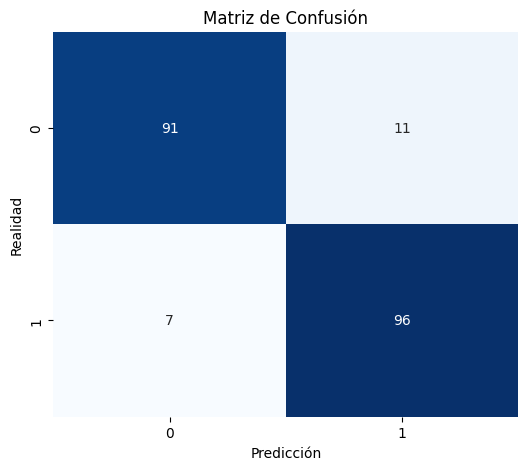

In [9]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0 
)

grid_search.fit(X_train, y_train)

print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor Accuracy en CV (validación): {grid_search.best_score_:.4f}")
print("="*40)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("\nEvaluación en Test Set:")
print(f"Accuracy final: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
# Usamos annot=True para ver los números y fmt='d' para que sean enteros
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

<div style="background-color:green;color:white">

<br>

- ¿Qué combinación obtiene mejor resultado?


- ¿Ha mejorado realmente frente al modelo inicial?


- ¿Cuánto tiempo tarda y por qué?



<br>

La mejor combinación es la profundidad en 10, el mínimo de muestras en 5 y el número de árboles en 50.

Mejora en todás las métricas sobre todo a la hora de acertar a la gente sana pasando de 81 a 91.

---

## Parte 5 – Interpretabilidad: dentro del bosque 

### 5.1 Visualización de un árbol

En esta parte se va a **analizar el interior del modelo Random Forest** para comprender **cómo toma decisiones**.

Un Random Forest está formado por **muchos árboles de decisión**. El modelo final no se basa en uno solo, sino en la **combinación de todos ellos**.
Sin embargo, para entender el funcionamiento interno del modelo, es útil **visualizar uno de esos árboles individuales**.

El objetivo **no es explicar el modelo completo**, sino:

* observar **qué variables utiliza**,
* entender **qué tipo de reglas aprende**,
* y reflexionar sobre **las limitaciones de la interpretabilidad** en modelos de conjunto.


---

### Pistas para la implementación

* Un `RandomForestClassifier` almacena los árboles entrenados en un **atributo interno**.
* Cada árbol puede visualizarse usando una función específica de `sklearn.tree`.
* Es recomendable:

  * fijar el tamaño de la figura,
  * limitar la profundidad del árbol representado,
  * mostrar los nombres de las variables,
  * y colorear los nodos para facilitar la interpretación.

📌 **Ayuda**
Consulta la documentación de:

* [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) para localizar dónde se almacenan los árboles entrenados.
* [plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) para identificar los parámetros que controlan la visualización, los nombres de las variables y la profundidad máxima.



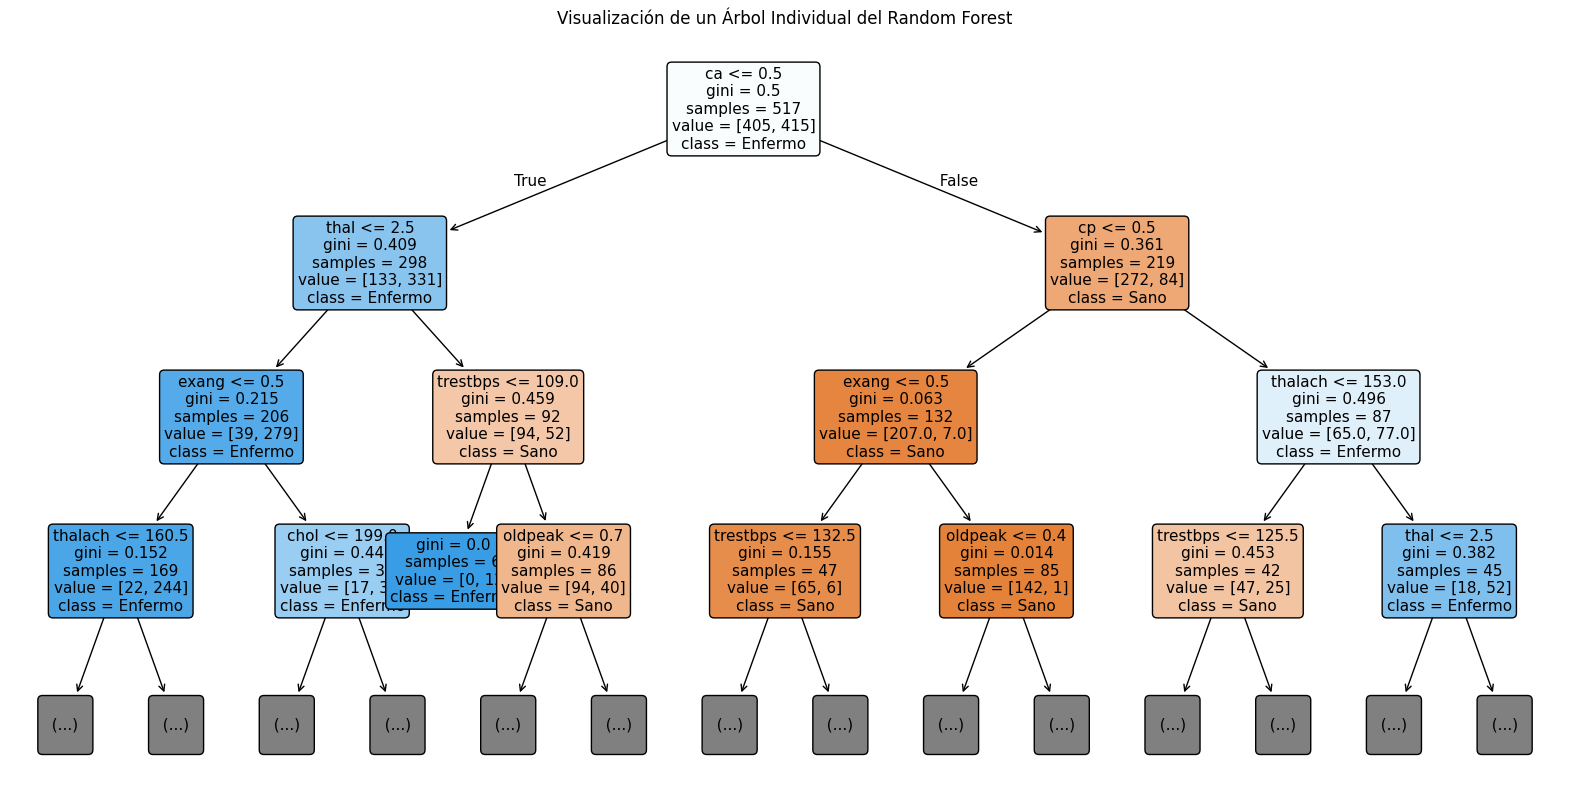

In [12]:
from sklearn.tree import plot_tree

best_rf = grid_search.best_estimator_

arbol_individual = best_rf.estimators_[0]

plt.figure(figsize=(20, 10))

plot_tree(arbol_individual,
          feature_names=X_train.columns,
          class_names=['Sano', 'Enfermo'],
          filled=True,
          rounded=True,
          max_depth=3,
          fontsize=11)

plt.title("Visualización de un Árbol Individual del Random Forest")
plt.show()

<div style="background-color:green;color:white">

<br>

**Explica:**

* Qué variable aparece primero


* Qué significa una condición tipo *chol <= 240*


* Por qué **no debemos mostrar este árbol a un médico como modelo final**


<br>

La que aparece primero es "ca" ya que el algoritmo ha calculado que es la variable más discriminante.

Es un punto de corte matemático, si el colesterol fuese mayor de 240 iria por una rama y si es menos o igual por otra.

Porque esto es solamente la decisión de un árbol, y en random forest lo que buscamos es el conjunto y la votación de las opiniones de decenas o cientos de árboles de decisión.

---

### 5.2 Importancia de variables

En este apartado se va a analizar **qué variables son más importantes para el modelo Random Forest** a la hora de realizar sus predicciones.

Un Random Forest toma decisiones combinando muchos árboles de decisión. En cada árbol, las variables no se usan todas por igual: algunas aparecen con más frecuencia y generan **mejores divisiones** que reducen más la incertidumbre del modelo.
A partir de esta información, el modelo puede estimar la **importancia relativa de cada variable**.

---


#### Pistas para la implementación

* Los modelos `RandomForestClassifier` calculan automáticamente la importancia de las variables tras el entrenamiento.
* Esta información se encuentra en un **atributo del modelo**.
* Para interpretarla correctamente:

  * es conveniente asociar cada valor con el nombre de su variable,
  * y ordenar los resultados para facilitar el análisis.

📌 **Ayuda**
Consulta la documentación de `RandomForestClassifier` para identificar el atributo que almacena la importancia de las variables y su significado.


    Variable  Importancia
2         cp     0.145016
11        ca     0.142762
12      thal     0.132523
7    thalach     0.114852
9    oldpeak     0.114230
8      exang     0.074220
0        age     0.065403
4       chol     0.057746
3   trestbps     0.051401
10     slope     0.051016
1        sex     0.035114
6    restecg     0.012179
5        fbs     0.003538


/tmp/ipykernel_719/1865095049.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=importancia_df, palette='viridis')


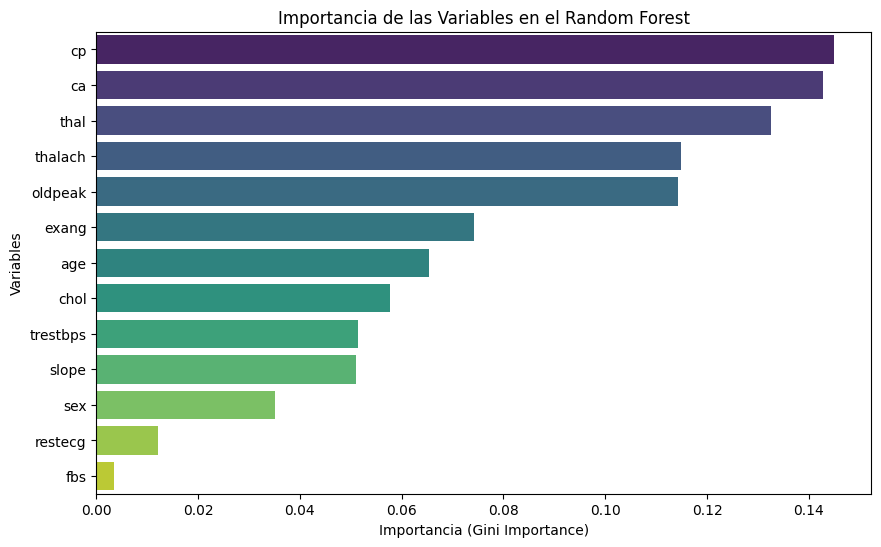

In [13]:
importancia_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': best_rf.feature_importances_
})

importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

print(importancia_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Variable', data=importancia_df, palette='viridis')
plt.title('Importancia de las Variables en el Random Forest')
plt.xlabel('Importancia (Gini Importance)')
plt.ylabel('Variables')
plt.show()

<div style="background-color:green;color:white">

<br>

- ¿Coincide con lo que esperarías médicamente?

- ¿Qué variable eliminarías si quisieras simplificar aún más?

<br>

Sí, ya que las variables mas importantes son el dolor de pecho, el número de vasos mayores y la talasemia que es un defecto sanguíneo.

La de azúcar en sangre en ayunas y la de electrocardiograma en reposo, ya que aportan poco comparado con las demás, sobre todo la del azucar en sangre en ayunas.

--

## Parte 6 – Comparación crítica de datasets

Entrena **el mismo modelo** con:

* dataset completo
* dataset de 4 variables


---

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

top_vars = ['cp', 'ca', 'thal', 'thalach']

X_train_red = X_train[top_vars]
X_test_red = X_test[top_vars]

rf_params = {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 30, 'random_state': 42}

model_full = RandomForestClassifier(**rf_params)
model_full.fit(X_train, y_train)
acc_full = accuracy_score(y_test, model_full.predict(X_test))

model_red = RandomForestClassifier(**rf_params)
model_red.fit(X_train_red, y_train)
acc_red = accuracy_score(y_test, model_red.predict(X_test_red))

print(f"Accuracy Modelo Completo: {acc_full:.4f}")
print(f"Accuracy Modelo 4 Vars:   {acc_red:.4f}")

Accuracy Modelo Completo: 0.9171
Accuracy Modelo 4 Vars:   0.8293


<div style="background-color:green;color:white">

<br>

Completa una tabla como esta:

| Dataset | Accuracy | Interpretabilidad | Riesgo de overfitting |
| ------- | -------- | ----------------- | --------------------- |
| Completo | 0.9171  |    Media/Baja     |        Medio          |
| Reducido | 0.8293  |     Muy alta      |        Bajo           |

<br>



<div style="background-color:green;color:white">

<br>

¿Qué modelo recomendarías *en un hospital pequeño* y por qué?


<br>

El modelo reducido, ya que un hospital pequeño tiene recursos limitados, y el aumento en gastos que supondría para la mejora en la precisión no les saldría rentable.
También el modelo reducido se puede ejecutar al instante no como el completo, además de que es mucho más interpretable.

---

## Parte 7 – Reflexión final

Responde brevemente (5–6 líneas cada una):

<div style="background-color:green;color:white">

<br>

1. ¿Por qué Random Forest es una buena elección aquí?

2. ¿Cuándo **no** usarías Random Forest?


3. ¿Qué mejorarías si tuvieras más datos?


<br>


Al usar las desisiones de múltiples árboles es muy robusto frente al overfitting y ofrece métricas de importancia de variables, lo cual es importante para justificar decisiones clínicas.

Cuando se trabaje con datos no estructurados como imágenes o audios o de muy alta dimensión, ya que las redes neuronales funcionan mejor. Tampoco si las predicciones son necesarias a tiempo real, ya que p`rocesar tantos árboles es lento.

